# Imports

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Reading the data

In [3]:
users = pd.read_csv('datasets/takehome_users.csv', parse_dates=["creation_time"])
user_engagement = pd.read_csv('datasets/takehome_user_engagement.csv', index_col="time_stamp",parse_dates=["time_stamp"])

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Create the `creation_delta` variable

In [5]:
# Create a creation delta column which 
# computes the time delta between time from account creation to user's last login
users['creation_delta'] =  pd.to_datetime(users['last_session_creation_time'], unit='s', origin='unix')-users['creation_time'] 

In [6]:
#Convert `creation_time` to unix timestamps for analysis 
users['creation_delta'].dtypes
users['creation_delta_ts'] = users['creation_delta'].astype(int)/ 10**9

In [7]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_delta,creation_delta_ts
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0 days,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,136 days,11750400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0 days,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1 days,86400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5 days,432000.0


# Create the response variable

In [8]:
user_engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [9]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_delta,creation_delta_ts
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,8823,1.200000e+04
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,59 days 05:19:53.471608,-2.438126e+09
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,144 days 04:07:55.235611,4.071793e+09
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0 days 00:00:00,-9.223372e+09
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0 days 00:00:00,-9.223372e+09
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,1 days 00:00:00,0.000000e+00
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,20 days 00:00:00,2.592000e+05
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,729 days 00:00:00,6.298560e+07


In [10]:
user_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


## Distinguish between adopted users and the rest

We compute visit counts per `user_id` in a 7 day window

In [11]:
user_engagement = user_engagement.sort_index()

In [12]:
_grouped = user_engagement.groupby("user_id").rolling('7D').visited.count()

In [13]:
user_engagement_7d_count = pd.DataFrame(_grouped)

In [14]:
user_engagement_7d_count = user_engagement_7d_count.rename(columns={"visited":"visit_7d_count"})

In [15]:
user_engagement_7d_count.head(20)

visit_7d_count
user_id time_stamp                         
1       2014-04-22 03:53:30             1.0
2       2013-11-15 03:45:04             1.0
        2013-11-29 03:45:04             1.0
        2013-12-09 03:45:04             1.0
        2013-12-25 03:45:04             1.0
        2013-12-31 03:45:04             2.0
        2014-01-08 03:45:04             1.0
        2014-02-03 03:45:04             1.0
        2014-02-08 03:45:04             2.0
        2014-02-09 03:45:04             3.0
        2014-02-13 03:45:04             3.0
        2014-02-16 03:45:04             2.0
        2014-03-09 03:45:04             1.0
        2014-03-13 03:45:04             2.0
        2014-03-31 03:45:04             1.0
3       2013-03-19 23:14:52             1.0
4       2013-05-22 08:09:28             1.0
5       2013-01-22 10:14:20             1.0
6       2013-12-19 03:37:06             1.0
7       2012-12-20 13:24:32             1.0

In [16]:
adopted_users = user_engagement_7d_count[user_engagement_7d_count['visit_7d_count'] >= 3]
adopted_users.head()

visit_7d_count
user_id time_stamp                         
2       2014-02-09 03:45:04             3.0
        2014-02-13 03:45:04             3.0
10      2013-02-19 22:08:03             3.0
        2013-03-02 22:08:03             3.0
        2013-03-05 22:08:03             3.0

In [17]:
adopted_user_ids = adopted_users.index.get_level_values(0)

In [18]:
adopted_user_ids_unique = list(set(list(adopted_user_ids)))

In [19]:
len(adopted_user_ids_unique)

1602

In [20]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_delta,creation_delta_ts
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0 days,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,136 days,11750400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0 days,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1 days,86400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5 days,432000.0


In [21]:
users['object_id'].dtypes

dtype('int64')

In [22]:
def filter_users(ser):
    if ser in adopted_user_ids_unique:
        return 1
    else:
        return 0

In [23]:
users['adopted'] = users['object_id'].apply(filter_users)

## Create a response variable `adopted` encoded column

In [24]:
# Convert categorical values to unique ids
users.creation_source = pd.Categorical(users.creation_source)
users['creation_source_code'] = users.creation_source.cat.codes

In [25]:
users.creation_source_code.head()

0    0
1    1
2    1
3    0
4    0
Name: creation_source_code, dtype: int8

In [26]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_delta,creation_delta_ts,adopted,creation_source_code
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0 days,0.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,136 days,11750400.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0 days,0.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1 days,86400.0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5 days,432000.0,0,0


# One hot encode the `creation_source` column

In [27]:
users_full = pd.concat([users, pd.get_dummies(users['creation_source'], prefix = 'c_source')], axis= 1)

In [28]:
users_full.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_delta,creation_delta_ts,adopted,creation_source_code,c_source_GUEST_INVITE,c_source_ORG_INVITE,c_source_PERSONAL_PROJECTS,c_source_SIGNUP,c_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0 days,0.0,0,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,136 days,11750400.0,1,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0 days,0.0,0,1,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1 days,86400.0,0,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5 days,432000.0,0,0,1,0,0,0,0


# Deal with missing values

In [29]:
# Dealing with missing values
users_full.isnull().any()

object_id                      False
creation_time                  False
name                           False
email                          False
creation_source                False
last_session_creation_time      True
opted_in_to_mailing_list       False
enabled_for_marketing_drip     False
org_id                         False
invited_by_user_id              True
creation_delta                  True
creation_delta_ts              False
adopted                        False
creation_source_code           False
c_source_GUEST_INVITE          False
c_source_ORG_INVITE            False
c_source_PERSONAL_PROJECTS     False
c_source_SIGNUP                False
c_source_SIGNUP_GOOGLE_AUTH    False
dtype: bool

In [30]:
users_full = users_full.fillna(method='ffill')


## Multiple Linear Regression

In [31]:
#Select relevant columns for analysis 
X_selected = users_full[['creation_delta_ts','opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'c_source_GUEST_INVITE', 'c_source_ORG_INVITE', 'c_source_PERSONAL_PROJECTS', 'c_source_SIGNUP', 'c_source_SIGNUP_GOOGLE_AUTH' ]]
X = users_full[['creation_delta_ts','opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'c_source_GUEST_INVITE', 'c_source_ORG_INVITE', 'c_source_PERSONAL_PROJECTS', 'c_source_SIGNUP', 'c_source_SIGNUP_GOOGLE_AUTH' ]].values
y = users_full['adopted'].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
print(regressor.intercept_, regressor.coef_)

-3.1374183087303282 [-7.61852306e-09 -3.10602748e-03  9.90645166e-03  1.28993361e-04
 -2.43871995e-07  9.94864131e-09 -3.11699286e-04]


In [34]:
coeff_df = pd.DataFrame(regressor.coef_, X_selected.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
creation_delta_ts,2.137696e-11
opted_in_to_mailing_list,3.258421e-03
enabled_for_marketing_drip,4.261299e-03
org_id,1.591696e-04
invited_by_user_id,-5.992170e-07
c_source_GUEST_INVITE,3.881693e-02
c_source_ORG_INVITE,-3.080346e-03
c_source_PERSONAL_PROJECTS,1.279235e-02
c_source_SIGNUP,-2.822409e-02
c_source_SIGNUP_GOOGLE_AUTH,-2.030484e-02


In [35]:
y_pred = regressor.predict(X_test)


In [36]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

In [37]:
df1

,Actual,Predicted
0,0,0.166425
1,0,0.137182
2,0,0.196168
3,0,0.023555
4,1,0.204036
5,0,0.163936
6,1,0.182154
7,0,0.012664
8,0,0.010931
9,0,0.225732


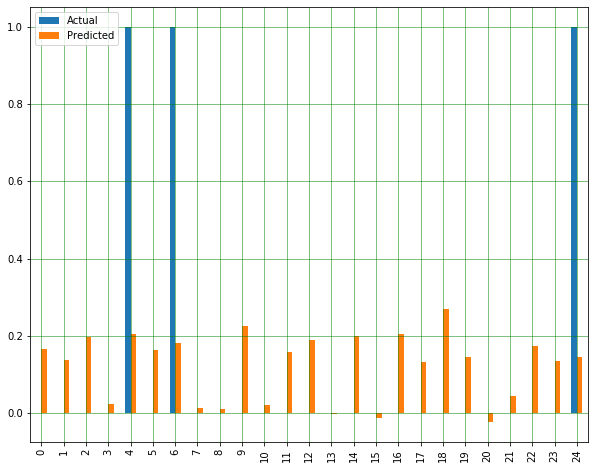

In [38]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## View statistical info generated by statsmodels

In [41]:
import statsmodels.api as sm

In [43]:
X_sm = sm.add_constant(X_selected) # adding a constant
 
model = sm.OLS(y, X_sm).fit()
predictions = model.predict(X_sm) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     90.80
Date:                Mon, 01 Jun 2020   Prob (F-statistic):          2.02e-164
Time:                        14:47:45   Log-Likelihood:                -3690.0
No. Observations:               12000   AIC:                             7400.
Df Residuals:                   11990   BIC:                             7474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Observing the results, we can say the our best predictors of future user adoption are the `creation_delta`, `c_source_GUEST_INVITE`, `c_source_PERSONAL_PROJECTS` and the`c_source_ORG_INVITE` variables (by order of importance). This makes sense as the more often the users login, the more likely they are to rely on the product. 

## Next steps 

Going forward, one path to explore would be to explore how the type of invitation as well as the inviting organization play a role in 'adoption'. It would also be worth exploring the variabliti of the `creation_delta` variable between the adopted and non adopted groups as well as to the reasons why `creation_delta` values tend to grow in order to find a way to retain more 'adopted' customers. 

# Plots 
## non adopted vs adopted customers invite plot

In [52]:
non_adopted = users_full[users_full['adopted'] == 0]

In [53]:
adopted = users_full[users_full['adopted'] == 1]

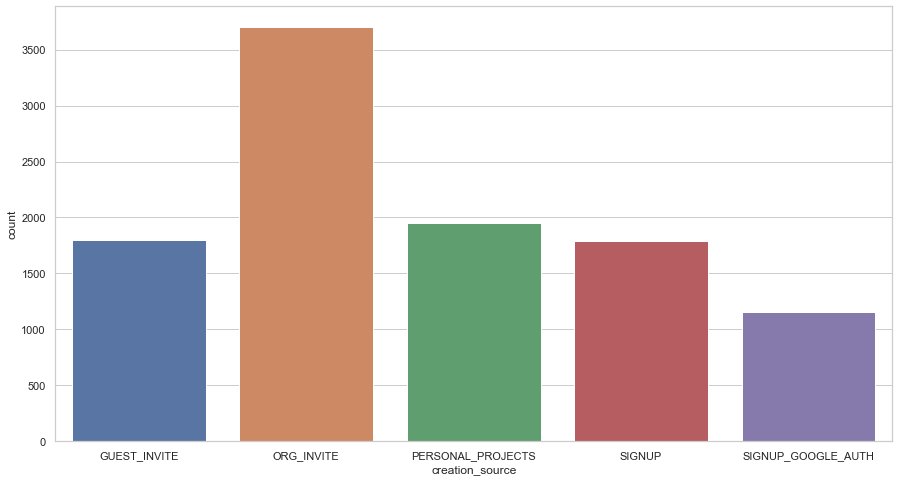

In [59]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
plt.tight_layout()
ax = sns.countplot(x="creation_source", data=non_adopted)

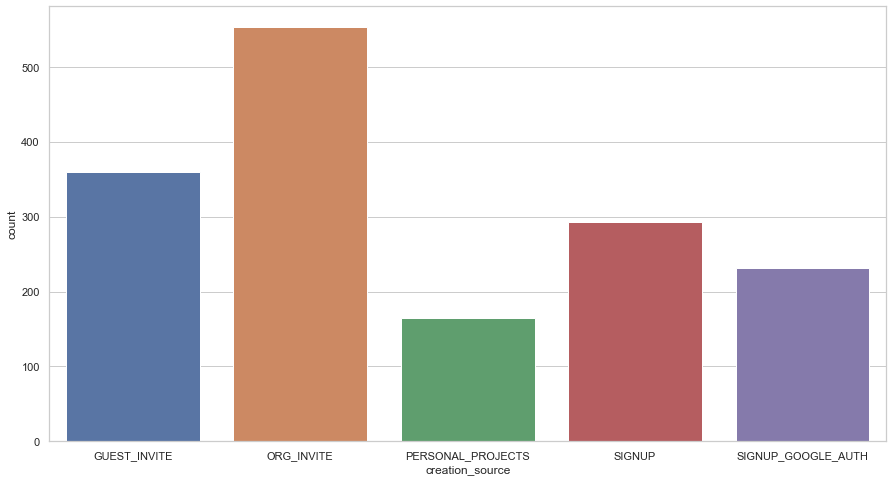

In [60]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
plt.tight_layout()
ax = sns.countplot(x="creation_source", data=adopted)

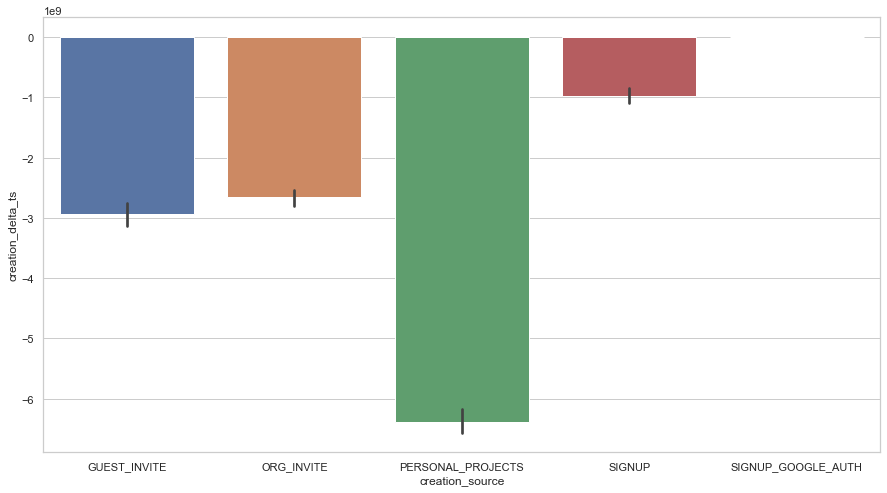

In [66]:
plt.figure(figsize=(15,8))
plt.tight_layout()
ax = sns.barplot(x="creation_source", y="creation_delta_ts", data=non_adopted)

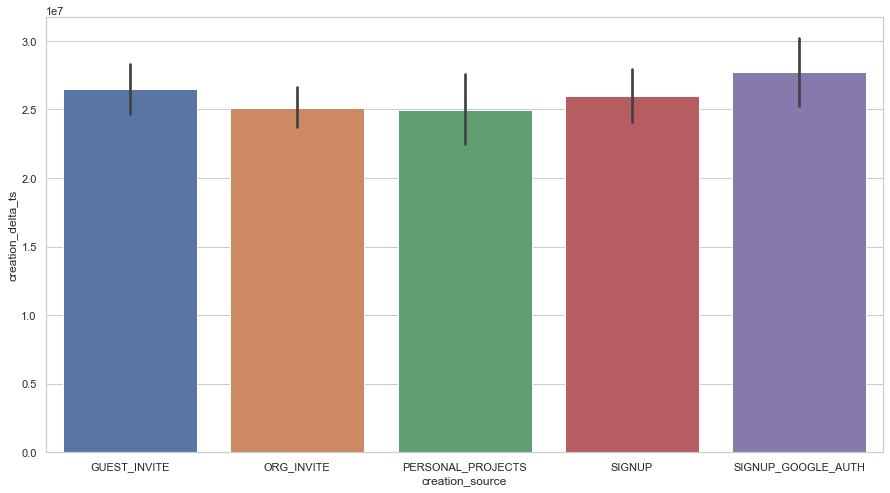

In [67]:
plt.figure(figsize=(15,8))
plt.tight_layout()
ax = sns.barplot(x="creation_source", y="creation_delta_ts", data=adopted)